In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, sosfiltfilt

def break_correct(data):
    corrected_data = np.copy(data)
    for i in range(1, len(data)):
        diff = data[i] - data[i - 1]
        if diff < -180:  # Assuming a break from 360 to 0
            corrected_data[i:] += 360
        elif diff > 180:  # Assuming a break from 0 to 360
            corrected_data[i:] -= 360
    return corrected_data

def signal_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    sos = butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

In [49]:
file_path = '../../dataset/basketball/test-2024-01-10-16-01-28.csv'
data = pd.read_csv(file_path).to_numpy()
timestamps = (data[:, 0] - data[0, 0])/ 1000
timestamps = np.linspace(0, timestamps[-1], len(timestamps))
c = data[:, 1]
b = data[:, 2]
tl = data[:, 3]
tr = data[:, 4]
r = data[:, 5]
p = data[:, 6]
y = data[:, 7]

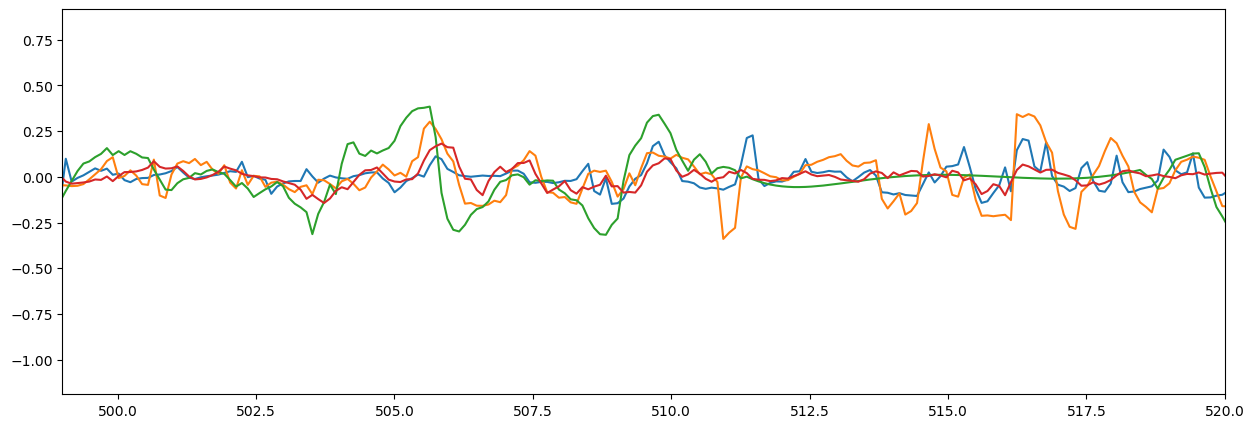

In [68]:
plt.figure(figsize=(15, 5))
plt.plot(timestamps, signal_filter(c, 0.2, 10))
plt.plot(timestamps, signal_filter(b, 0.2, 10))
plt.plot(timestamps, signal_filter(tl, 0.2, 10))
plt.plot(timestamps, signal_filter(tr, 0.2, 10))

plt.xlim(499, 520)
plt.show()

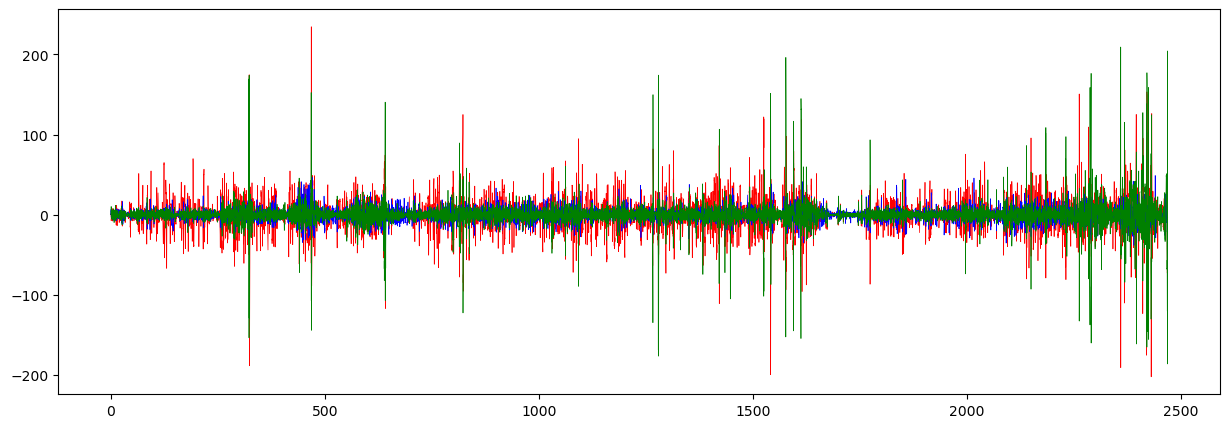

In [51]:
yf = break_correct(y)

# Highpass filter to remove drift (assuming sampling rate of 100 Hz, and cutoff frequency of 0.1 Hz)
fs = 10
cutoff = 0.2
yf = signal_filter(yf, cutoff, fs)
pf = signal_filter(p, cutoff, fs)
rf = signal_filter(r, cutoff, fs)

plt.figure(figsize=(15, 5))
# plt.plot(timestamps, y, 'r--', lw=0.5)
# plt.plot(timestamps, p, 'b--', lw=0.5)
# plt.plot(timestamps, r, 'g--', lw=0.5)
plt.plot(timestamps, yf, 'r', lw=0.5)
plt.plot(timestamps, pf, 'b', lw=0.5)
plt.plot(timestamps, rf, 'g', lw=0.5)


# plt.xlim(264, 300)

(400.0, 500.0)

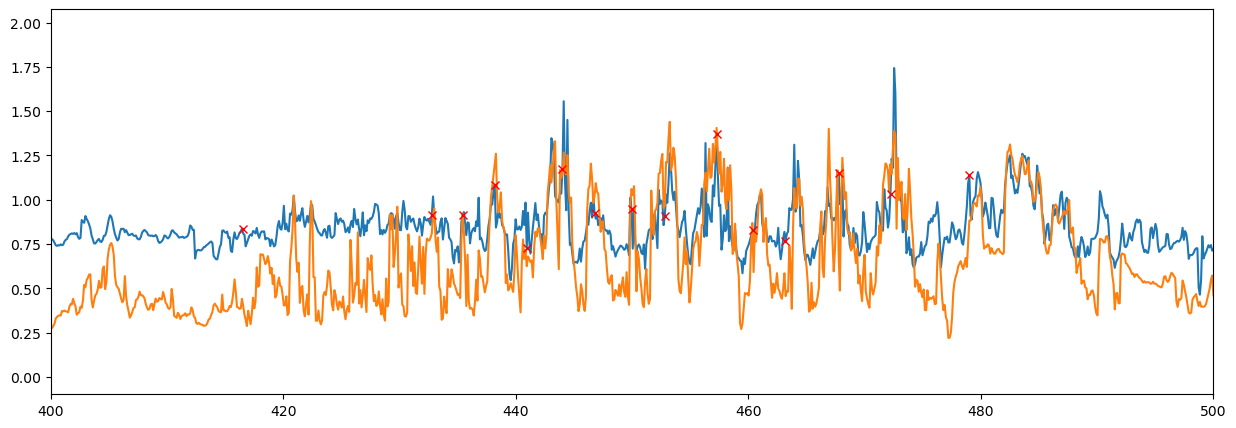

In [86]:
plt.figure(figsize=(15, 5))

events = pd.read_csv('../videos/basketball/cough_event.txt', header=None).to_numpy().squeeze()
plt.plot(timestamps, c)
plt.plot(timestamps, b)
for event in events:
    plt.plot(event, c[np.where(np.abs(timestamps - event) <= 8e-2)[0][0]], 'rx')

plt.xlim(400, 500)